## Thin film interference? simulation
### with change of thickness at a given wavelength


*** Air / glass / air ***



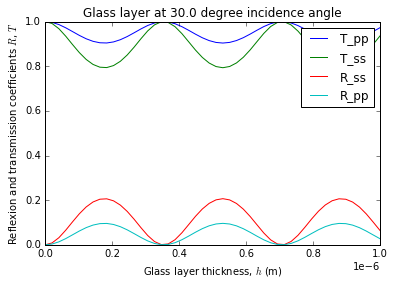

In [17]:
#!/usr/bin/python
# encoding: utf-8

# Berreman4x4 example
# Author: O. Castany

# The simplest example: a homogeneous glass layer in air

import numpy, Berreman4x4
from Berreman4x4 import c, pi
import matplotlib.pyplot as pyplot

print("\n*** Air / glass / air ***\n")

# Materials:
air = Berreman4x4.IsotropicNonDispersiveMaterial(1.0)
glass = Berreman4x4.IsotropicNonDispersiveMaterial(1.5)
CNC = Berreman4x4.IsotropicNonDispersiveMaterial(1.55)

# Layer and half-spaces:
layer = Berreman4x4.HomogeneousIsotropicLayer(glass)
front = back = Berreman4x4.IsotropicHalfSpace(air)

# Structure:
s = Berreman4x4.Structure(front, [layer], back)

# Wavelength and wavenumber:
lbda = 1e-6
k0 = 2*pi/lbda

# Incidence angle (Kx = n k0 sin(Φ):
"""
'Phi' is the angle of the wavetraveling to the right with respect to the horizontal.     
'Kx' : Reduced wavenumber,      
'k0' : wavenumber in vacuum,    kx = n k0 sin(Φ)
"""
angle = 30
Kx = sin(angle*pi/180)
# Returns : angle Phi in radians.
angle = front.get_Phi_from_Kx(Kx) * 180/pi

# Variation of the reflexion and transmission coefficients with the
# thickness of the glass layer:
h_list = numpy.linspace(0, 1.0e-6)
data = Berreman4x4.DataList()
for h in h_list:
    layer.setThickness(h)
    data.append(s.evaluate(Kx,k0))

# Extract the power coefficients
coeff_names = ("T_pp","T_ss","R_ss","R_pp")
values = [data.get(name) for name in coeff_names]

# Prepare plot...
d = numpy.vstack(values).T
fig = pyplot.figure()
ax = fig.add_subplot("111")
lines = ax.plot(h_list, d)
ax.legend(lines, coeff_names)
ax.set_title("Glass layer at {:.1f} degree incidence angle".format(angle))
ax.set_xlabel(r"Glass layer thickness, $h$ (m)")
ax.set_ylabel(r"Reflexion and transmission coefficients $R$, $T$")
fmt = ax.xaxis.get_major_formatter()
fmt.set_powerlimits((-3,3))
pyplot.show()

## Thin film interference 

## Incident angle of chiral structure


Transmission in the middle of the stop-band...

Eigenvalues of the Jones transmission matrix:
[ 0.776+0.06j   0.032-0.001j]
Corresponding power transmission:
[ 0.605  0.001]
Corresponding eigenvectors:
[[ 0.729+0.j     0.310+0.605j]
 [ 0.024+0.684j  0.734+0.j   ]]
Normalization to the 'p' componant:
[[ 1.000 +0.000e+00j  1.000 +7.272e-17j]
 [ 0.033 +9.378e-01j  0.492 -9.612e-01j]]
Ratio 's'/'p':
[[ 0.938  1.08 ]]
Complex angle (°) (+90°: L, -90°: R)
[[ 87.99  -62.878]]


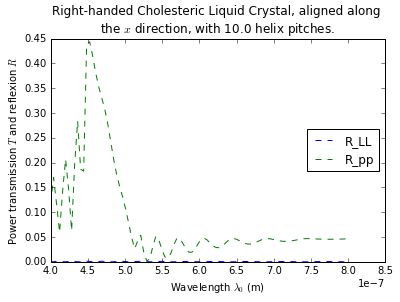

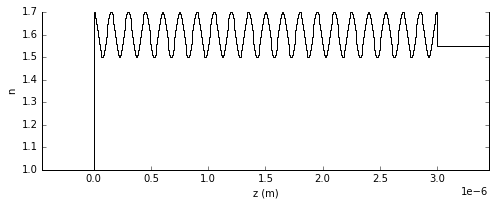

In [20]:
#!/usr/bin/python
# encoding: utf-8

# Berreman4x4 example
# Author: O. Castany, C. Molinaro

# Example of a cholesteric liquid crystal

import numpy, Berreman4x4
from numpy import sin, sqrt, abs
from Berreman4x4 import c, pi, e_y
import matplotlib.pyplot as pyplot

# Materials
glass = Berreman4x4.IsotropicNonDispersiveMaterial(1.55)
air = Berreman4x4.IsotropicNonDispersiveMaterial(1.0)
front = Berreman4x4.IsotropicHalfSpace(air)
back = Berreman4x4.IsotropicHalfSpace(glass)

# Liquid crystal oriented along the x direction
(no, ne) = (1.5, 1.7)
Dn = ne-no
n_med = (ne + no)/2
LC = Berreman4x4.UniaxialNonDispersiveMaterial(no, ne)  # ne along z
R = Berreman4x4.rotation_v_theta(e_y, pi/2) # rotation of pi/2 along y
LC = LC.rotated(R)                          # apply rotation from z to x
# Cholesteric pitch:
p = 0.3e-6
# One half turn of a right-handed helix:
TN = Berreman4x4.TwistedMaterial(LC, p/2, angle=+pi, div=20)

# Inhomogeneous layer, repeated layer, and structure
IL = Berreman4x4.InhomogeneousLayer(TN)
N = 20      # number half pitch repetitions
h = N * p/2
L = Berreman4x4.RepeatedLayers([IL], N)
s = Berreman4x4.Structure(front, [L], back)

# Normal incidence: 
Kx = 0

# Calculation parameters
lbda_min, lbda_max = 0.4e-6, 0.8e-6   # (m)
lbda_B = p * n_med
lbda_list = numpy.linspace(lbda_min, lbda_max, 100)
k0_list = 2*pi/lbda_list

############################################################################
# Analytical calculation for the maximal reflection
R_th = numpy.tanh(Dn/n_med*pi*h/p)**2
lbda_B1, lbda_B2 = p*no, p*ne

############################################################################
# Calculation with Berreman4x4
data = Berreman4x4.DataList([s.evaluate(Kx,k0) for k0 in k0_list])

T_pp = data.get('T_pp')
T_ps = data.get('T_ps')
T_ss = data.get('T_ss')
T_sp = data.get('T_sp')

# Transmission coefficients for incident unpolarized light:
T_pn = 0.5 * (T_pp + T_ps)
T_sn = 0.5 * (T_sp + T_ss)
T_nn = T_sn + T_pn

# Transmission coefficients for 's' and 'p' polarized light, with 
# unpolarized measurement.
T_ns = T_ps + T_ss
T_np = T_pp + T_sp

###########################################################################
# Text output: eigenvalues and eigenvectors of the transmission matrix for 
# a wavelength in the middle of the stop-band.
i = numpy.argmin(abs(lbda_list-lbda_B))     # index for stop-band center
T = data[i].T_ti                            # transmission matrix
eigenvalues, eigenvectors = numpy.linalg.eig(T)
numpy.set_printoptions(precision=3)
print("\nTransmission in the middle of the stop-band...\n")
print("Eigenvalues of the Jones transmission matrix:")
print(eigenvalues)
print("Corresponding power transmission:")
print(abs(eigenvalues)**2)
print("Corresponding eigenvectors:")
print(eigenvectors)
# Note: the transformation matrix to the eigenvector basis is
# B = numpy.matrix(eigenvectors), and the matrix B⁻¹ T B is diagonal.
print("Normalization to the 'p' componant:")
print(eigenvectors/eigenvectors[0,:])
print("Ratio 's'/'p':")
print(abs(eigenvectors[1,:]/eigenvectors[0,:]))
print("Complex angle (°) (+90°: L, -90°: R)")
print(180/pi*numpy.angle(eigenvectors[1,:]/eigenvectors[0,:]))
# We observe that the eigenvectors are nearly perfectly polarized circular waves

###########################################################################
# Jones matrices for the circular wave basis

# Right-circular wave is reflected in the stop-band.
# R_LR, T_LR close to zero.
# R_RR = data.get('R_RR')
R_LL = data.get('R_LL')
R_pp = data.get('R_pp')
#T_RR = data.get('T_RR')

# Left-circular wave is transmitted in the full spectrum.
# T_RL, R_RL, R_LL close to zero, T_LL close to 1.
#T_LL = data.get('T_LL')
#R_LL = data.get('R_LL')


############################################################################
# Plotting
fig = pyplot.figure()
ax = fig.add_subplot("111")

# ax.plot(lbda_list, R_RR, '--', label='R_RR')
ax.plot(lbda_list, R_LL, '--', label='R_LL')
ax.plot(lbda_list, R_pp, '--', label='R_pp')


ax.legend(loc='center right', bbox_to_anchor=(1.00, 0.50))

ax.set_title("Right-handed Cholesteric Liquid Crystal, aligned along \n" + 
             "the $x$ direction, with {:.1f} helix pitches.".format(N/2.))
ax.set_xlabel(r"Wavelength $\lambda_0$ (m)")
ax.set_ylabel(r"Power transmission $T$ and reflexion $R$")
fmt = ax.xaxis.get_major_formatter()
fmt.set_powerlimits((-3,3))

stack = s.drawStructure()
pyplot.show()





Transmission in the middle of the stop-band...

Eigenvalues of the Jones transmission matrix:
[-0.649-0.428j -0.012-0.001j]
Corresponding power transmission:
[  6.043e-01   1.355e-04]
Corresponding eigenvectors:
[[ 0.728+0.j     0.309+0.623j]
 [ 0.023+0.685j  0.719+0.j   ]]
Normalization to the 'p' componant:
[[ 1.000+0.j     1.000+0.j   ]
 [ 0.032+0.941j  0.460-0.927j]]
Ratio 's'/'p':
[[ 0.941  1.035]]
Complex angle (°) (+90°: L, -90°: R)
[[ 88.042 -63.628]]


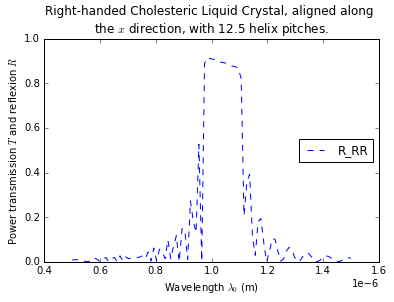

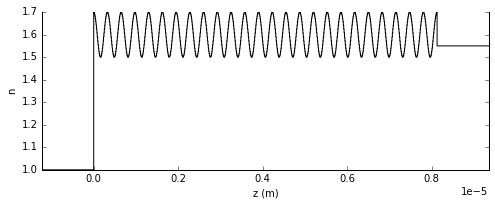

In [35]:
#!/usr/bin/python
# encoding: utf-8

# Berreman4x4 example
# Author: O. Castany, C. Molinaro

# Example of a cholesteric liquid crystal

import numpy, Berreman4x4
from numpy import sin, sqrt, abs
from Berreman4x4 import c, pi, e_y
import matplotlib.pyplot as pyplot

# Materials
glass = Berreman4x4.IsotropicNonDispersiveMaterial(1.55)
air = Berreman4x4.IsotropicNonDispersiveMaterial(1.0)

front  = Berreman4x4.IsotropicHalfSpace(air)
back = Berreman4x4.IsotropicHalfSpace(glass)



# Liquid crystal oriented along the x direction
(no, ne) = (1.5, 1.7)
Dn = ne-no
n_med = (ne + no)/2
LC = Berreman4x4.UniaxialNonDispersiveMaterial(no, ne)  # ne along z
R = Berreman4x4.rotation_v_theta(e_y, pi/2) # rotation of pi/2 along y
LC = LC.rotated(R)                          # apply rotation from z to x
# Cholesteric pitch:
p = 0.65e-6
# One half turn of a right-handed helix:
TN = Berreman4x4.TwistedMaterial(LC, p/2, angle=+pi, div=35)

# Inhomogeneous layer, repeated layer, and structure
IL = Berreman4x4.InhomogeneousLayer(TN)
N = 25      # number half pitch repetitions
h = N * p/2
L = Berreman4x4.RepeatedLayers([IL], N)
s = Berreman4x4.Structure(front, [L], back)

# Normal incidence: 
Kx = 0.0

# Calculation parameters
lbda_min, lbda_max = 0.5e-6, 1.5e-6   # (m)
lbda_B = p * n_med
lbda_list = numpy.linspace(lbda_min, lbda_max, 100)
k0_list = 2*pi/lbda_list

############################################################################
# Analytical calculation for the maximal reflection
R_th = numpy.tanh(Dn/n_med*pi*h/p)**2
lbda_B1, lbda_B2 = p*no, p*ne

############################################################################
# Calculation with Berreman4x4
data = Berreman4x4.DataList([s.evaluate(Kx,k0) for k0 in k0_list])

T_pp = data.get('T_pp')
T_ps = data.get('T_ps')
T_ss = data.get('T_ss')
T_sp = data.get('T_sp')

# Transmission coefficients for incident unpolarized light:
T_pn = 0.5 * (T_pp + T_ps)
T_sn = 0.5 * (T_sp + T_ss)
T_nn = T_sn + T_pn

# Transmission coefficients for 's' and 'p' polarized light, with 
# unpolarized measurement.
T_ns = T_ps + T_ss
T_np = T_pp + T_sp

###########################################################################
# Text output: eigenvalues and eigenvectors of the transmission matrix for 
# a wavelength in the middle of the stop-band.
i = numpy.argmin(abs(lbda_list-lbda_B))     # index for stop-band center
T = data[i].T_ti                            # transmission matrix
eigenvalues, eigenvectors = numpy.linalg.eig(T)
numpy.set_printoptions(precision=3)
print("\nTransmission in the middle of the stop-band...\n")
print("Eigenvalues of the Jones transmission matrix:")
print(eigenvalues)
print("Corresponding power transmission:")
print(abs(eigenvalues)**2)
print("Corresponding eigenvectors:")
print(eigenvectors)
# Note: the transformation matrix to the eigenvector basis is
# B = numpy.matrix(eigenvectors), and the matrix B⁻¹ T B is diagonal.
print("Normalization to the 'p' componant:")
print(eigenvectors/eigenvectors[0,:])
print("Ratio 's'/'p':")
print(abs(eigenvectors[1,:]/eigenvectors[0,:]))
print("Complex angle (°) (+90°: L, -90°: R)")
print(180/pi*numpy.angle(eigenvectors[1,:]/eigenvectors[0,:]))
# We observe that the eigenvectors are nearly perfectly polarized circular waves

###########################################################################
# Jones matrices for the circular wave basis

# Right-circular wave is reflected in the stop-band.
# R_LR, T_LR close to zero.
R_RR = data.get('R_RR')
T_RR = data.get('T_RR')

# Left-circular wave is transmitted in the full spectrum.
# T_RL, R_RL, R_LL close to zero, T_LL close to 1.
T_LL = data.get('T_LL')
R_LL = data.get('R_LL')


############################################################################
# Plotting
fig = pyplot.figure()
ax = fig.add_subplot("111")



ax.plot(lbda_list, R_RR, '--', label='R_RR')

ax.legend(loc='center right', bbox_to_anchor=(1.00, 0.50))

ax.set_title("Right-handed Cholesteric Liquid Crystal, aligned along \n" + 
             "the $x$ direction, with {:.1f} helix pitches.".format(N/2.))
ax.set_xlabel(r"Wavelength $\lambda_0$ (m)")
ax.set_ylabel(r"Power transmission $T$ and reflexion $R$")
fmt = ax.xaxis.get_major_formatter()
fmt.set_powerlimits((-3,3))

stack = s.drawStructure()
pyplot.show()


